## **[An Introduction to Exceedance Probability Forecasting](https://towardsdatascience.com/an-introduction-to-exceedance-probability-forecasting-4c96c0e7772c)**
### **Predicting the chance of extreme values in time series using Python**

**Exceedance probability forecasting** is the problem of estimating the probability that a time series will exceed a predefined threshold in a predefined future period.

In a previous post I briefly described 6 problems that arise with time series data, including exceedance probability forecasting. Here I will dive deeper into this task. After some basic definitions I will explain why this problem matters, and how you can apply it in your own time series using Python.

<center> <p>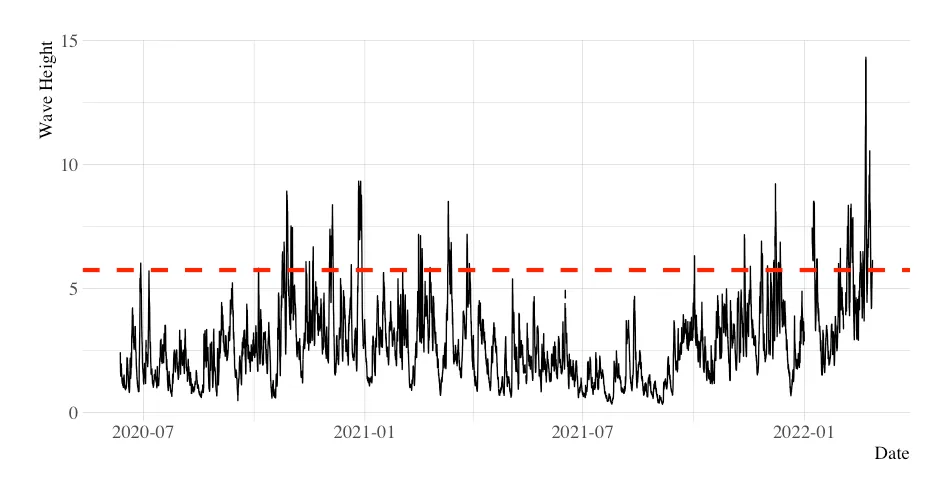</p> </center>

Figure 1: Ocean wave height time series. Predicting whether it exceeds a predefined threshold (red dashed line) is important to ensure the safety of maritime operations.

Exceedance probability forecasting is relevant in many domains, for example, economics. Central banks rely on estimates of whether the inflation rate will exceed some threshold. If the probability is high, then central banks may respond by increasing interest rates.

**Essentially, this problem is important in scenarios where extreme values (i.e. the tails of the distribution) are highly relevant.** Another example, which is depicted in Figure 1, is related to ocean data analytics. Short-term forecasting the height of waves is important to estimate energy production. But large waves pose concerns to the safety of maritime operations (e.g. safe passage of vessels), and it’s important to anticipate them.

**The probabilistic output is desirable because it carries more information to support decision-making, especially when the stakes are high.** The forecast “there’s a 10% chance of rain” is more informative than simply stating “it will not rain”, though most likely it won’t rain. A risk averse person might be keen to grab an umbrella.

### **Hands On**
There are two main approaches that you can use to solve exceedance probability problems: binary classification or a forecasting ensemble. Let’s overview and code both options.

#### **Binary Classification**
Exceedance relates to binary events. Therefore, **the most natural way to model exceedance probability is by framing the problem as a binary classification** one. The explanatory variables represent recent past observations, along with any extra variables you may have available. The target variable is binary, indicating whether the event occurs, i.e. if the threshold is exceeded. Then, we can estimate exceedance probability by using a probabilistic classifier such as Logistic Regression.

Here’s a Python mockup to do just that. I’ll use a time series related to wave height which you can get here. You can visualize part of the time series in Figure 1. I’ll skip basic time series preprocessing for conciseness.

In [15]:
tseries

,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,SeaTemperature,Hmax,THmax,MeanCurDirTo,MeanCurSpeed
0,UTC,NaN,s,degrees_true,s,cm,degree_C,cm,s,degrees_true,m/s
1,2022-01-01T00:00:00Z,SmartBay Wave Buoy,4.17,169.05495,3.96,154.0,10.16,272.0,4.91,0.351648,0.216
2,2022-01-01T00:05:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.16,NaN,NaN,NaN,NaN
3,2022-01-01T00:10:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.11,NaN,NaN,1.934066,0.17
4,2022-01-01T00:15:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
58965,2022-11-23T10:35:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.94,NaN,NaN,NaN,NaN
58966,2022-11-23T10:40:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.94,NaN,NaN,53.01099,0.256
58967,2022-11-23T10:45:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.94,NaN,NaN,NaN,NaN
58968,2022-11-23T10:50:00Z,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,10.94,NaN,NaN,67.51649,0.281


<Axes: xlabel='time'>

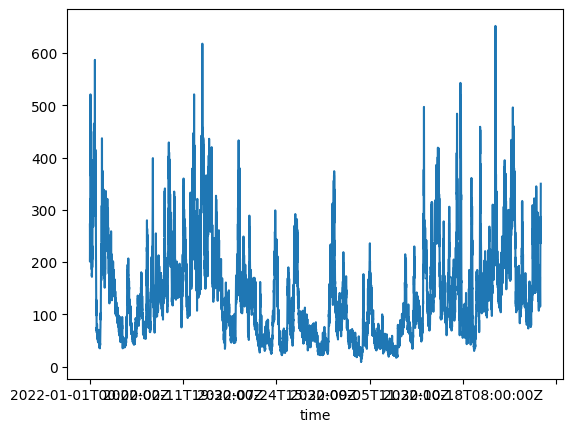

In [17]:
tseries_ = tseries.dropna()['Hmax'].astype(float)
tseries_.index = tseries.dropna()['time']
tseries_.plot()

In [20]:
import numpy as np
import pandas as pd
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# reading the time series (pd.Series format)
tseries = pd.read_csv('../data/smart_buoy.csv')
tseries_ = tseries.dropna()['Hmax'].astype(float)
tseries_.index = tseries.dropna()['time']
tseries = deepcopy(tseries_)
# you can simulate some data with:
# tseries = pd.Series(np.random.random(100))

# using 3 lags -- the no. of observation we look back to model the next value of the series
N_LAGS = 3
# Constructing a set of observations based on past recent values (lags)
tseries_df = pd.concat([tseries.shift(i) for i in range(N_LAGS, -1, -1)], axis=1)
# Assigning column names and dropping na's
tseries_df.columns = ['t-' + str(i) for i in list(reversed(range(N_LAGS)))] + ['t+1']
tseries_df = tseries_df.dropna().reset_index(drop=True)

# the target variable is the column 't+1' representing the next value of the series
y = tseries_df['t+1']
# Removing the target to create the predictor variables
X = tseries_df.drop('t+1', axis=1)

# basic train/test split -- you may want a more robust cross-validation approach
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# setting the threshold to the 95th percentile
thr = np.quantile(y_train, .95)

# transforming the numeric target to a binary one 
y_train_binary = (y_train >= thr).astype(int)
y_test_binary = (y_test >= thr).astype(int)

# training a probabilistic classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train_binary)

# predicting exceedance probability
exceedance_prob_clf = classifier.predict_proba(X_test)[:, 1]

We start by reading the data and transforming the time series (of *pd.Series* type) into a set of observations which we can feed to a learning algorithm (lines 8 — 21). Then, we split the data into train and test (line 24), and set up the threshold to be the 95*th* percentile (line 27). We set up the threshold arbitrarily, but this value strongly depends on the dataset. The binary response variables are created using the threshold (lines 30–31), and then the classifier is trained (lines 34 — 35). Finally, we retrieve the exceedance probability for testing observations in line 38.

### **Forecasting Ensembles**

The alternative to a classification approach is to use a forecasting ensemble. Essentially, we train several forecasting models to predict the future values of the time series. Then, **we can estimate the exceedance probability by computing the ratio of models that forecast a value that exceeds the threshold.**

Ensemble-based approaches are common in fields related to environmental science, for example, meteorology or hydrology. In these domains, different models are built by changing the initial conditions. In machine learning, we can do this, for example, by using different learning algorithms or different training sets.

Below is a mockup for creating a forecasting ensemble. In this case, we will use a Random Forest, which trains several decision trees on different training sets. This is a continuation of the previous script, so I will jump straight into creating the model.

In [21]:
# Using the RF as ensemble of trees
from sklearn.ensemble import RandomForestRegressor

# Training the model
forecasting_ensemble = RandomForestRegressor()
# Here we use the numerical target
## which represents the next value of the time series
forecasting_ensemble.fit(X_train, y_train)

# Retrieving the predictions from the trees.
per_tree_pred = [tree.predict(X_test) for tree in forecasting_ensemble.estimators_]
per_tree_df = pd.DataFrame(per_tree_pred).T

# Computing the ratio of trees which predict a value above the threshold
exceedance_prob_fe = per_tree_df.apply(lambda x: np.mean(x > thr), axis=1).values

c:\Users\seung\anaconda3\envs\Dyn_Ensemble_for_TSA\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\seung\anaconda3\envs\Dyn_Ensemble_for_TSA\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\seung\anaconda3\envs\Dyn_Ensemble_for_TSA\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\seung\anaconda3\envs\Dyn_Ensemble_for_TSA\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\seung\anaconda3\envs\Dyn_Ensemble_for_TSA\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


First, we create the forecasting ensemble (lines 1 — 8). Note that we now use the numeric response variable that represents the next value of the series. Then (lines 11 — 12), we retrieve the numeric prediction of each ensemble member (in this case, a tree). Finally, the exceedance probability is computed in line 15.

#### **Evaluating Predictions**
We can evaluate each approach using metrics such as AUC (area under the ROC curve) or the Brier score. These measure the accuracy of probabilistic predictions. See the script below.

In [23]:
from sklearn.metrics import brier_score_loss, roc_auc_score

roc_rf = roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_fe)
roc_logit_r = roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_clf)
print(roc_logit_r, roc_rf)

brier_rf = brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_fe)
brier_logit_r = brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_clf)
print(brier_logit_r, brier_rf)

0.985785605951177 0.973246635610766
0.02309596967855301 0.026300846129739888


### **Pros and Cons of Each Method**
Depending on the input dataset, one of these approaches may perform better. But, aside from performance, there are other aspects to consider that can make one of these strategies preferable relative to the other.

Adopting a regression approach via an ensemble has two main advantages relative to a classifier. 
1. The first is an **integrated model** because the predictions of the ensemble can be used not only to estimate the exceedance probability but also the future values of the time series. 
2. The second advantage is **threshold flexibility** because this parameter is not fixed in advance. A classification approach fixes the threshold during training, and it cannot be changed for inference. On the other hand, a regression model follows a lazy approach regarding the threshold. Therefore, in a given instant we can use the same model to estimate the exceedance probability for different thresholds. This allows us to draw an exceedance probability curve as depicted in Figure 2.



<center> <p>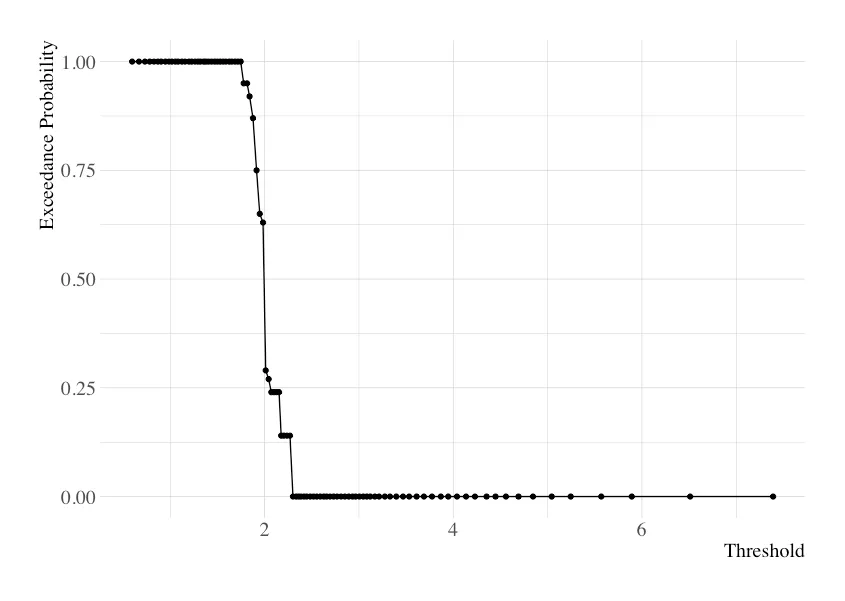</p> </center>

On the other hand, ensemble approaches are known to be computationally heavy which precludes their application in many domains.

### **Extensions**
#### **Peaks-over-threshold (POT)**
A related problem to exceedance probability forecasting is peaks-over-threshold analysis. But, rather than attempting to predict exceedance events, the goal of peaks-over-threshold methods is to study the statistical properties of the observations that exceed the threshold.

#### **Beyond A Single Threshold**
While exceedance probability forecasting usually refers to binary events (whether or not the exceedance occurs), multiple thresholds can also be defined.

An example of this is the triple barrier method used in quantitative trading. Stock market traders may be interested in predicting buy, sell, or hold signals according to price movements. Exceeding a positive threshold in terms of predicted price returns can be used as a buy signal; the opposite (predicted price returns below a negative threshold) can represent a sell trigger. If none of the thresholds is met, then the trader should hold the current position.

### **Take Aways**
- Exceedance probability forecasting is the process of estimating the probability that a time series will exceed a predefined threshold in a predefined future period;
- This problem is relevant in scenarios where extreme values are important to predict;
- There are two main approaches to solve this task: a binary classification model or a forecasting ensemble. Each has their pros and cons.

#### **Further Readings**
[1] Taylor, James W., and Keming Yu. “Using auto‐regressive logit models to forecast the exceedance probability for financial risk management.” Journal of the Royal Statistical Society: Series A (Statistics in Society) 179.4 (2016): 1069–1092.

[2] Méndez, Fernando J., et al. “Estimation of the long‐term variability of extreme significant wave height using a time‐dependent peak over threshold (pot) model.” Journal of Geophysical Research: Oceans 111.C7 (2006).